In [1]:
import Pkg
#Pkg.add("Gurobi")
#Pkg.build("Gurobi")
#Pkg.add("DataFrames")
Pkg.activate(@__DIR__)
Pkg.instantiate()

Activating environment at `C:\Users\mmart\Desktop\TFM\Julia\notebooks\Project.toml`


In [27]:
include("../src/input_data/read_data.jl")
include("../JuMP/main_JuMP.jl") 

H0 = 40

Constants(10, 10, 5, 2, 265, 1, 1)

In [28]:
T=P+1
PP=[p for p in 1:P]
PPP=[p for p in 0:T]
PP0=[p for p in 0:P]
PPT=[p for p in 1:T]
QQ=[q for q in 1:Q]
CC=[c for c in 1:C]

#create bj_dict
bj_dict = Dict{Int, Array{Int,1}}()
bj_init = [1,5]
for p in PPP
    l = Array{Int,1}()
    for q in QQ
        if p == 0
            push!(l, bj_init[q])
        elseif p == T
            push!(l, 0)
        else
            push!(l, bj[p])
        end
    end
    bj_dict[p] = l
end

function travel_time(current_bay::Int, target_bay::Int, CTS::Constants)
    if current_bay == 0 || target_bay == 0
        return(0)
    else
        return(abs(current_bay - target_bay)*CTS.tt)
    end
end

function clearance_travel_time(i::Int, j::Int, v::Int, w::Int, bj_dict::Dict{Int, Array{Int,1}}, CTS::Constants)
    delta = (CTS.delta + 1)*abs(v-w)
    li = bj_dict[i][v]
    lj = bj_dict[j][w]
    if (v < w) && (i != j) && (li > lj - delta)
        return((li - lj + delta)*CTS.tt)
    elseif (v > w) && (i != j) && (li < lj + delta)
        return((lj - li + delta)*CTS.tt)
    else
        return(0)
    end
end

clearance_travel_time (generic function with 1 method)

In [29]:
using JuMP, Gurobi
model = JuMP.direct_model(Gurobi.Optimizer(OutputFlag=0, Threads=4))


#if positions p, s are performed consecutively by crane q
@variable(model, x[p=0:T, s=0:T, q=1:Q], Bin)
#if positions p is filled with container i
@variable(model, w[p=0:T, i=1:C], Bin)
#if position s starts after the completion time of task p
@variable(model, z[p=1:P, s=1:P], Bin)

#completion time of task p
@variable(model, t_load[p=0:T], Int, lower_bound=0, upper_bound=CTS.H)
#completion required time to perform task p
@variable(model, t_task[p=0:T], lower_bound=0, upper_bound=CTS.H)
#completion time of crane q
@variable(model, t_crane[q=1:Q], lower_bound=0, upper_bound=CTS.H)
#makespan
#@variable(model, makespan, lower_bound=0, upper_bound=CTS.H)


#objective function
@objective(model, Min, 1*t_load[T] + 0*sum(t_crane[q] for q in QQ));
#@objective(model, Min, t_load[T])

Academic license - for non-commercial use only


In [30]:
#constraints for variables initialization and boundaries
@constraint(model, [p=0:T, q=1:Q], x[p,p,q] == 0)
@constraint(model, [p=1:P], z[p,p] == 0)

@constraint(model, t_load[0] == 0)
#@constraint(model, t_load[T] <= CTS.H)

@constraint(model, t_task[0] == 0)
@constraint(model, t_task[T] == 0)

@constraint(model, [i=1:C], w[0,i] == 0)
@constraint(model, [i=1:C], w[T,i] == 0);

In [31]:
#constraints regarding tasks selection (position-container combination)
@constraint(model, [i=1:C], sum(w[p,i] for p in subset_pos(PP, tasks_by_position, i)) == 1)
@constraint(model, [p=1:P], sum(w[p,i] for i in subset_pos(CC, tasks_by_position, p)) == 1)

@constraint(model, [p=1:P], t_task[p] == sum(task_times[p,i]*w[p,i] for i in subset_pos(CC, tasks_by_position, p)));

In [32]:
#relate crane times and makespan
@constraint(model, [q=1:Q], t_crane[q] <= t_load[T]);

In [33]:
#constraints regarding tasks assignment
@constraint(model, [q=1:Q], sum(x[0,s,q] for s in PPT) == 1)
@constraint(model, [q=1:Q], sum(x[p,T,q] for p in PP0) == 1)

@constraint(model, [p=1:P], sum(sum(x[p,s,q] for s in PPT) for q in QQ) == 1)

for p in PP
    for q in QQ
        @constraint(model, sum(x[s,p,q] for s in PP0) - sum(x[p,s,q] for s in PPT) == 0)
    end
end

In [34]:
#constraints regarding tasks assignment (precedences)
for s in PP
    for p in prec[s]
        @constraint(model, t_load[p] + 2*t_task[s] - t_load[s] <= 0)
        @constraint(model, z[p,s] + z[s,p] == 1)
    end
end

In [35]:
#guarante correct calculation of loading times and task assignments
for p in PPP
    for s in PPP
        for q in setdiff(Set(QQ), Set(subset_crane_pos(CTS, p, bj)), Set(subset_crane_pos(CTS, s, bj)))
            @constraint(model, x[p,s,q]==0)
        end
        if p != s
            for q in QQ
                @constraint(model, t_load[p] + travel_time(bj_dict[p][q], bj_dict[s][q], CTS) + 2*t_task[s] - t_load[s] <= CTS.H*(1-x[p,s,q]))
            end
        end
    end
end

for p in PP
    for s in PP
        if p != s
            @constraint(model, t_load[p] + 2*t_task[s] - t_load[s] <= CTS.H*(1-z[p,s]))
            @constraint(model, t_load[s] - 2*t_task[s] - t_load[p] <= CTS.H*z[p,s])
        end
    end
end

In [36]:
#quay cranes initialization (after initial dummy task)
for s in PPP
    for q in QQ
        @constraint(model, travel_time(bj_dict[0][q], bj_dict[s][q], CTS) + 2*t_task[s] - t_load[s] <= CTS.H*(1-x[0,s,q]))
    end
end

In [37]:
#guarantee task assignments and crane clearance
for p in PP
    for s in PP
        for v in QQ
            for w in QQ
                if p < s && clearance_travel_time(p, s, v, w, bj_dict, CTS) > 0
                    @constraint(model, sum(x[u,p,v] for u in PP0) + sum(x[u,s,w] for u in PP0) <= 1 + z[p,s] + z[s,p])
                    @constraint(model, t_load[p] + clearance_travel_time(p, s, v, w, bj_dict, CTS) + 2*t_task[s] - t_load[s] <= CTS.H*(3 - z[p,s] - sum(x[u,p,v] for u in PP0) - sum(x[u,s,w] for u in PP0)))
                    @constraint(model, t_load[s] + clearance_travel_time(p, s, v, w, bj_dict, CTS) + 2*t_task[p] - t_load[p] <= CTS.H*(3 - z[s,p] - sum(x[u,p,v] for u in PP0) - sum(x[u,s,w] for u in PP0)))
                end
            end
        end
    end
end

## Solution

In [38]:
@time JuMP.optimize!(model) # Old syntax: status = JuMP.solve(model)

 69.782891 seconds (4 allocations: 160 bytes)


In [39]:
makespan = JuMP.value.(t_load)[T]

34.0

In [40]:
sol_x = Dict{Int, Array}()
for q=1:Q
    for p=0:T
        for s=0:T
            if JuMP.value.(x)[p,s,q] == 1
                if haskey(sol_x, q) == false
                    sol_x[q] = Array{NamedTuple{(:start_time, :pos, :next_pos, :qc),Tuple{Int64,Int64,Int64,Int64}}, 1}()
                end
                push!(sol_x[q], (start_time=JuMP.value.(t_load)[p]-2*JuMP.value.(t_task)[p], pos=p, next_pos=s, qc=q))
            end                
        end
    end
    sort!(sol_x[q], by = x->x.start_time)
end

sol_x[1]

6-element Array{NamedTuple{(:start_time, :pos, :next_pos, :qc),NTuple{4,Int64}},1}:
 (start_time = 0, pos = 0, next_pos = 6, qc = 1)  
 (start_time = 2, pos = 6, next_pos = 4, qc = 1)  
 (start_time = 9, pos = 4, next_pos = 3, qc = 1)  
 (start_time = 13, pos = 3, next_pos = 2, qc = 1) 
 (start_time = 20, pos = 2, next_pos = 1, qc = 1) 
 (start_time = 26, pos = 1, next_pos = 11, qc = 1)

In [41]:
sol_x[2]

6-element Array{NamedTuple{(:start_time, :pos, :next_pos, :qc),NTuple{4,Int64}},1}:
 (start_time = 0, pos = 0, next_pos = 10, qc = 2) 
 (start_time = 4, pos = 10, next_pos = 8, qc = 2) 
 (start_time = 9, pos = 8, next_pos = 7, qc = 2)  
 (start_time = 11, pos = 7, next_pos = 5, qc = 2) 
 (start_time = 20, pos = 5, next_pos = 9, qc = 2) 
 (start_time = 30, pos = 9, next_pos = 11, qc = 2)

In [42]:
sol_w = Dict{Int, Int}()
for p=1:P
    for i=1:C
        if JuMP.value.(w)[p,i] == 1
            sol_w[p] = i             
        end
    end
end
sol_w[0] = 0
sol_w[T] = 0

sol_w;

In [43]:
function update_ls(LS::LoadingSequence, t::NamedTuple{(:start_time, :pos, :next_pos, :qc),Tuple{Int64,Int64,Int64,Int64}}, sol_w::Dict{Int, Int}, CTS::Constants)
    if t.pos != 0
        LS.len += 1
        LS.tasks_left -= 1
        push!(LS.filled_pos, t.pos)
        push!(LS.loaded_cont, sol_w[t.pos])
    end
    push!(LS.order, (task=Task(t.pos, bj_dict[t.pos][t.qc], sol_w[t.pos], JuMP.value.(t_task)[t.pos]), start_time=t.start_time, qc=t.qc))
end

update_ls (generic function with 1 method)

In [44]:
#init Loading Sequence and Quay Cranes
LS = init_ls(CTS)
QC = init_qc(CTS)

#update loading sequence with model solution
while LS.tasks_left > 0
    task = [(start_time=CTS.H+1,pos=0,next_pos=0,qc=0)]
    for q=1:Q
        if length(sol_x[q])>0 && sol_x[q][1].start_time < task[1].start_time
            task = [sol_x[q][1]]
        elseif length(sol_x[q])>0 && sol_x[q][1].start_time == task[1].start_time
            push!(task, sol_x[q][1])
        end
    end

    for t in task
        update_ls(LS, t, sol_w, CTS)
        if sol_x[t.qc][1] == t
            deleteat!(sol_x[t.qc], 1)
        end
    end
end

In [45]:
#get QC moves and times
function get_qc_moves(LS::LoadingSequence, CTS::Constants)
    QC_MOVES=Dict{Int, Array{NamedTuple{(:bay, :start_time, :time),Tuple{Int64,Int64,Int64}}, 1}}()
    for q = 1:CTS.Q
        l=Array{NamedTuple{(:bay, :start_time, :time),Tuple{Int64,Int64,Int64}}, 1}()
        for t in LS.order
            if t.qc == q
                push!(l, (bay=t.task.b, start_time=t.start_time, time=t.task.t))
            end
        end
        QC_MOVES[q]=l
    end
    return(QC_MOVES)
end

#get QC travel times
function get_qc_travel(QC_MOVES::Dict{Int, Array{NamedTuple{(:bay, :start_time, :time),Tuple{Int64,Int64,Int64}}, 1}}, CTS::Constants)
    QC_TRAVEL=Dict{Int, Array{NamedTuple{(:start_bay, :end_bay, :start_time, :end_time),Tuple{Int64,Int64,Int64,Int64}}, 1}}()
    for q = 1:CTS.Q
        l=Array{NamedTuple{(:start_bay, :end_bay, :start_time, :end_time),Tuple{Int64,Int64,Int64,Int64}}, 1}()
        for t = 1:length(QC_MOVES[q])-1
            if QC_MOVES[q][t].bay != QC_MOVES[q][t+1].bay
                start_time = QC_MOVES[q][t].start_time + 2*QC_MOVES[q][t].time
                end_time = QC_MOVES[q][t+1].start_time
                start_bay = QC_MOVES[q][t].bay
                end_bay = QC_MOVES[q][t+1].bay
                if end_time - start_time <= abs(start_bay - end_bay)*CTS.tt
                    push!(l, (start_bay = start_bay, end_bay = end_bay, start_time = start_time, end_time = end_time))
                else
                    push!(l, (start_bay = start_bay, end_bay = start_bay, start_time = start_time, end_time=end_time - abs(start_bay - end_bay)*CTS.tt))
                    push!(l, (start_bay = start_bay, end_bay = end_bay, start_time = end_time - abs(start_bay - end_bay)*CTS.tt, end_time = end_time))
                end
            end
        end
        QC_TRAVEL[q]=l
    end
    return(QC_TRAVEL)
end

get_qc_travel (generic function with 1 method)

In [46]:
function check_tasks(LS::LoadingSequence, CTS::Constants)
    if length(LS.filled_pos) == P && length(LS.loaded_cont) == C && length(setdiff(LS.filled_pos, collect(1:P))) == 0 && length(setdiff(LS.loaded_cont, collect(1:C))) == 0
        return(true)
    else
        return(false)
    end
end

function check_clearance(QC::Array{QuayCrane, 1}, q::Int, target_bay::Int, CTS::Constants)
    if QC[q-1].current_bay < target_bay - CTS.delta && QC[q+1].current_bay > target_bay + CTS.delta
        return(true)
    end
    return(false)
end

function check_prec(LS::LoadingSequence, task::Task, precedences::Dict)
    for req in precedences[task.p]
        if !(req in LS.filled_pos)
            print("trying to add position, but still missing")
            print(setdiff(precedences[task.p],LS.filled_pos))
            return(false)
        end
    end
    return(true)
end




function check_solution(LS::LoadingSequence, QC::Array{QuayCrane, 1}, CTS::Constants)
    #check positions and containers
    if check_tasks(LS, CTS) == false
        return(false)
    end
    
    #check precedences
    for task in LS.order
        if task[1].p != 0
            if check_prec(LS, task[1], prec) == false
                return(false)
            end
        end
    end

    #check the QC constraints
    QC_MOVES=get_qc_moves(LS, CTS)
    for clock in 1:CTS.H
        current_cranes=Array{Tuple{Int, Int}, 1}()
        for (key, value) in QC_MOVES
            if clock == 1
                for i = 1: length(value)-1
                    #check loading + travel time
                    if value[i].start_time + 2*value[i].time + travel_time(value[i].bay, value[i+1].bay, CTS) > value[i+1].start_time
                        print("wrong task/travel time")
                        return(false)
                    end
                    #check that cranes respect bays
                    if !(value[i].bay in QC[key].available_bays)
                        print("wrong bays")
                        return(false)
                    end
                end
                if !(value[length(value)].bay in QC[key].available_bays)
                    print("wrong bays")
                    return(false)
                end
            end

            #s'hauria de millorar per si una grua te idle time
            for tuple in value
                if tuple.start_time <= clock && clock <= tuple.start_time + tuple.time
                    push!(current_cranes, (key, tuple.bay))
                end
            end
        end

        #check clearance
        sort(current_cranes, by = first)
        for b = 1:length(current_cranes)-1
            if current_cranes[b][1] - current_cranes[b+1][1] < CTS.delta
                print("wrong clearance")
                return(false)
            end
        end
    end
    return(true)
end


check_solution (generic function with 1 method)

In [47]:
check_solution(LS, QC, CTS)

true

In [48]:
using Gadfly
using DataFrames
Gadfly.set_default_plot_size(25cm, 10cm)

#plot solution
function plot_solution(LS::LoadingSequence, QC::Array{QuayCrane, 1}, CTS::Constants)
    QC_MOVES=get_qc_moves(LS, CTS)
    QC_TRAVEL=get_qc_travel(QC_MOVES, CTS)

    list_moves=[]
    list_travel=[]
    for n=1:CTS.Q
        push!(list_moves, DataFrame(Bay = [x.bay for x in QC_MOVES[n]], Start = [x.start_time for x in QC_MOVES[n]], End = [x.start_time+2*x.time for x in QC_MOVES[n]], var = map(i -> "Quay Crane " * string(i), n)))
        push!(list_travel, DataFrame(start_bay = [x.start_bay for x in QC_TRAVEL[n]], end_bay = [x.end_bay for x in QC_TRAVEL[n]], start_time = [x.start_time for x in QC_TRAVEL[n]], end_time = [x.end_time for x in QC_TRAVEL[n]], var = map(i -> "Quay Crane " * string(i), n)))
    end
    df_moves=vcat(list_moves...)
    df_travel=vcat(list_travel...)

    #plot scale
    xsc  = Scale.x_continuous(minvalue=0, maxvalue=makespan)
    ysc  = Scale.y_continuous(minvalue=0, maxvalue=CTS.J+1)
    #plot(df, x = :Start, xend = :Time, y = :Bay, yend = :Bay, color = :var, Geom.segment(filled=false), Theme(line_width=1cm, major_label_font="CMU Serif",minor_label_font="CMU Serif",
          #     major_label_font_size=16pt,minor_label_font_size=14pt), xsc, ysc)
    
    layer1 = layer(df_moves, x = :Start, xend = :End, y = :Bay, yend = :Bay, color = :var, Geom.segment(filled=false), Theme(alphas=[0.5], line_width=1cm, major_label_font="CMU Serif",minor_label_font="CMU Serif",
               major_label_font_size=16pt,minor_label_font_size=14pt))
    layer2 = layer(df_travel, x = :start_time, xend = :end_time, y = :start_bay, yend = :end_bay, color = :var, Geom.segment(filled=false), Theme(line_style=[:dot] ,line_width=0.05cm, major_label_font="CMU Serif",minor_label_font="CMU Serif",
               major_label_font_size=16pt,minor_label_font_size=14pt))

    plot(layer1, layer2,xsc, ysc)

end

plot_solution (generic function with 1 method)

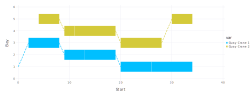

In [49]:
plot_solution(LS, QC, CTS)

In [50]:
QC_MOVES = get_qc_moves(LS,CTS)
QC_MOVES[1]

6-element Array{NamedTuple{(:bay, :start_time, :time),Tuple{Int64,Int64,Int64}},1}:
 (bay = 1, start_time = 0, time = 0) 
 (bay = 3, start_time = 2, time = 3) 
 (bay = 2, start_time = 9, time = 2) 
 (bay = 2, start_time = 13, time = 3)
 (bay = 1, start_time = 20, time = 3)
 (bay = 1, start_time = 26, time = 4)

In [51]:
QC_MOVES[2]

6-element Array{NamedTuple{(:bay, :start_time, :time),Tuple{Int64,Int64,Int64}},1}:
 (bay = 5, start_time = 0, time = 0) 
 (bay = 5, start_time = 4, time = 2) 
 (bay = 4, start_time = 9, time = 1) 
 (bay = 4, start_time = 11, time = 4)
 (bay = 3, start_time = 20, time = 4)
 (bay = 5, start_time = 30, time = 2)